In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter

pd.set_option('precision', 2)
np.set_printoptions(precision=2)

con = sqlite3.connect('../data/database.sqlite')
reviews = pd.read_sql('SELECT * FROM reviews', con)
genres = pd.read_sql('SELECT * FROM genres', con)
con.close()


Averages:
best_new_music    0.05
score             7.01
dtype: float64

Standard Deviation:
best_new_music    0.22
score             1.29
dtype: float64


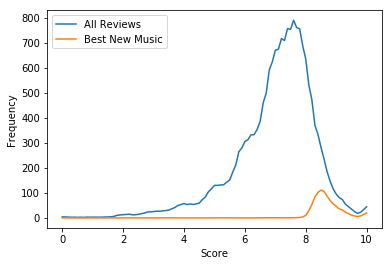

In [3]:
print('\nAverages:')
print(np.mean(reviews[['best_new_music', 'score']]))

print('\nStandard Deviation:')
print(np.std(reviews[['best_new_music', 'score']]))

g = reviews.groupby('score')
info = g['best_new_music'].agg(['sum','count']).reset_index()

plt.plot(info['score'], savgol_filter(info['count'], 5, 1), label = 'All Reviews') 
plt.plot(info['score'], savgol_filter(info['sum'], 5, 1), label = "Best New Music") 
plt.legend(loc = 'best')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

Sanity check: what are the 10.0 albums that are not best new music?

In [5]:
idx = (reviews.best_new_music == 0) & (reviews.score == 10.0)
reviews.loc[idx, ['artist', 'title', 'pub_date'] ]

,artist,title,pub_date
200,bob dylan,blood on the tracks,2016-10-30
355,brian eno,another green world,2016-09-18
451,stevie wonder,songs in the key of life,2016-08-21
530,nina simone,in concert,2016-07-30
654,neil young,tonight's the night,2016-06-26
706,kate bush,hounds of love,2016-06-12
857,prince,"sign ""o"" the times",2016-04-30
858,prince,1999,2016-04-30
861,"prince, the revolution",purple rain,2016-04-29
862,prince,dirty mind,2016-04-29


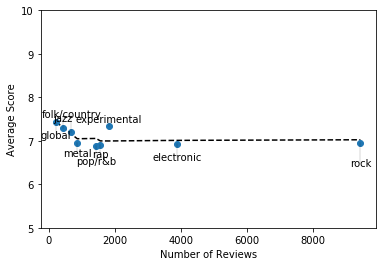

In [6]:
genre_data = pd.merge(reviews[['reviewid','score']], genres, 
                  on = 'reviewid')

g = genre_data.groupby('genre')
table = g['score'].agg(['count', 'mean', 'std']).reset_index()

# plot the average at each level of count
avgline = table.groupby('count')['mean'].mean().reset_index()
avgline['mean'] = savgol_filter(avgline['mean'], 5, 1)
plt.plot(avgline['count'], avgline['mean'],'k--')

plt.plot(table['count'],table['mean'],'o', alpha = 1)

for j, row in table.iterrows():
    curr_avg = float(avgline.loc[avgline['count'] == row['count'], 'mean'])
    jitter = np.random.uniform(0.1, high = 0.5)
    if row['mean'] < curr_avg: jitter*= -1.0
    
    plt.plot([row['count'], row['count']], [row['mean'], row['mean'] + jitter], 'k-', alpha = 0.1)
    plt.text(row['count'], row['mean'] + jitter, row['genre'], 
             ha = 'center', va = 'center')

plt.ylabel('Average Score')
plt.xlabel('Number of Reviews')
plt.ylim([5, 10])
plt.show()

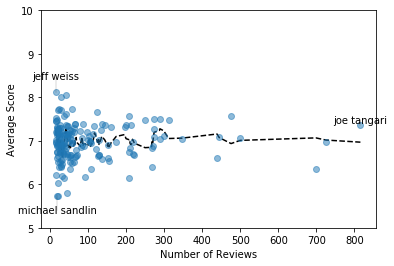

In [7]:
g = reviews.groupby('author')
table = g.score.agg(('mean','std','count'))
table['ratio'] = table['mean'] / table['count']

# remove labels with only a handful of reviews
table = table.loc[table['count'] > 15]

# plot the average at each level of count
avgline = table.groupby('count')['mean'].mean().reset_index()
avgline['mean'] = savgol_filter(avgline['mean'], 5, 1)
plt.plot(avgline['count'], avgline['mean'],'k--')

# plot each author as a point
plt.plot(table['count'], table['mean'],'o', alpha = 0.5)

# identify some standouts
items = [
         table['mean'].idxmax(), 
         table['mean'].idxmin(),
         table['count'].idxmax()
        ]

for idx in items:
    
    x, y = table.loc[idx, 'count'], table.loc[idx, 'mean']
    curr_avg = float(avgline.loc[avgline['count'] == x, 'mean'])
        
    jitter = np.random.uniform(0.1, high = 0.5)
    if y < curr_avg: jitter*= -1.0
    
    plt.plot([x, x], [y, y + jitter], 'k-', alpha = 0.1)
    plt.text(x, y + jitter, idx, ha = 'center', va = 'center')

plt.ylabel('Average Score')
plt.xlabel('Number of Reviews')
plt.ylim([5, 10])
plt.show()

In [10]:
g = reviews.groupby('author')
table = g.score.agg(('mean','std','count'))
table['ratio'] = table['mean'] / table['count']

In [12]:
table = table.loc[table['count'] > 15]

In [17]:
avgline = table.groupby('count')['mean'].mean().reset_index()
avgline['mean'] = savgol_filter(avgline['mean'], 5, 1)

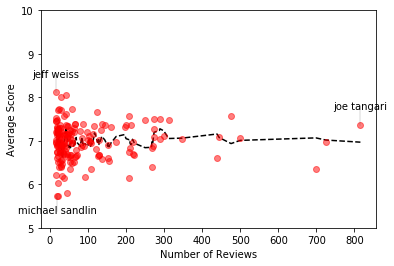

In [31]:

plt.plot(avgline['count'], avgline['mean'],'k--')
# plot each author as a point
# https://matplotlib.org/api/markers_api.html
plt.plot(table['count'], table['mean'],'ro', alpha = 0.5)

items = [
         table['mean'].idxmax(), 
         table['mean'].idxmin(),
         table['count'].idxmax()
        ]

for idx in items:
    
    x, y = table.loc[idx, 'count'], table.loc[idx, 'mean']
    curr_avg = float(avgline.loc[avgline['count'] == x, 'mean'])
        
    jitter = np.random.uniform(0.1, high = 0.5)
    if y < curr_avg: jitter*= -1.0
    
    plt.plot([x, x], [y, y + jitter], 'k-', alpha = 0.1)
    plt.text(x, y + jitter, idx, ha = 'center', va = 'center')
    
    
plt.ylabel('Average Score')
plt.xlabel('Number of Reviews')
plt.ylim([5, 10])
plt.show()